# Center of Gravity Method with Automatic Differentiation

In [0]:
!pip install --upgrade jax jaxlib

Requirement already up-to-date: jax in /usr/local/lib/python3.6/dist-packages (0.1.46)
     |████████████████████████████████| 25.5MB 93.0MB/s 
  Found existing installation: jaxlib 0.1.26
    Uninstalling jaxlib-0.1.26:
      Successfully uninstalled jaxlib-0.1.26


# Case 1
## Cost Function $= \sum_i distance_i \times (\frac{cost}{distance \cdot unit})_i \times units_i$ where $distance_i$ is the distance between location $i$ and distribution center at iteration $t$

Costo Inicial: 11022.59
Costo Final: 1031.51
[[ -1.9415425 -79.915695 ]]


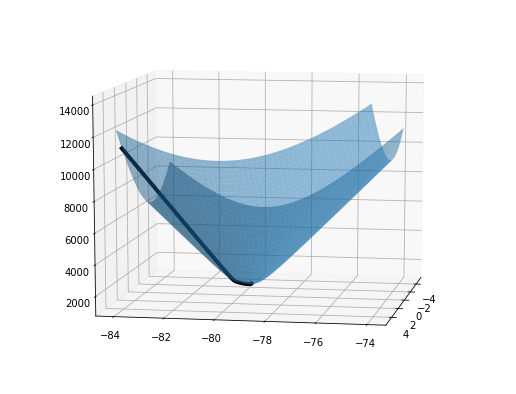

In [0]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import jax.numpy as np
import numpy as np2

FIGSIZE = (9, 7)

#Initial locationl of depots/distribution centers
x0=np.array([[4.0,-84.0]])

#Locations of centers of demand or supply
x_n = np.array([[-0.97,-80.7],
                [-1.05, -80.45],
               [-2.15, -79.92],
               [-1.81, -79.53],
               [-1.03, -79.47]])

#Quantities of demand/supply for each center
cantidades = np.array([[250],[200],[700],[150],[300]]) 
#Cost/(unit x distance)
costos = np.array([[1],[1],[1],[1],[1]])

def distancias(x,y):
  x_rp = np.repeat(x,x_n.shape[0],0).reshape(-1,1)
  y_rp = np.repeat(y,x_n.shape[0],0).reshape(-1,1)
  dist_x = (x_rp - x_n[:,:1])**2
  dist_y = (y_rp - x_n[:,1:2])**2
  return np.sqrt(dist_x+dist_y).reshape((-1,1))

def funcion_costo(x0):
  x = np.array([[x0[0,0]]])
  y = np.array([[x0[0,1]]])
  dist       = distancias(x,y)
  dist_costo = cantidades*costos*dist
  return np.sum(dist_costo)

def funcion_costo_2(x,y):
  dist       = distancias(x,y)
  dist_costo = cantidades*costos*dist
  return np.sum(dist_costo)

gradiente_funcion = jit(grad(funcion_costo))

xs=[]
ys=[]
f2 = []

xs.append(x0[0,0])
ys.append(x0[0,1])
f2.append(funcion_costo(x0))

print("Costo Inicial: {:0.2f}".format(funcion_costo(x0)))

method = 'grad_desc'

for i in range(100):
  if method == 'newton':
    loss_val = funcion_costo(x0)
    loss_vec  = np.array([[loss_val, loss_val]])
    x0 -= 0.005*loss_vec/gradiente_funcion(x0)
  elif method == 'grad_desc':
    step = 0.0001*gradiente_funcion(x0)
    x0 -= step
  xs.append(x0[0,0])
  ys.append(x0[0,1])
  f2.append(funcion_costo(x0))

print("Costo Final: {:0.2f}".format(funcion_costo(x0)))
print(x0)
xs = np.array(xs).reshape(-1,)
ys = np.array(ys).reshape(-1,)
f2 = np.array(f2)


X, Y = np2.meshgrid(np2.linspace(-5., 5., 50), np2.linspace(-84., -74., 50))
func_vec = np2.vectorize(funcion_costo_2)
f        = func_vec(X,Y)
indices = (slice(None, None, 4), slice(None, None, 4))

fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d', azim=10,elev=10)
ax.plot_surface(X, Y, f, shade=True, linewidth=2, antialiased=True,alpha=0.5)
ax.plot3D(xs, ys, f2, color='black', lw=4)

# Case 2 (using the error as cost function)
## Cost function $= \sqrt{(x_{t+1}-x_t)^2+(y_{t+1}-y_t)^2}$ where $x_t,y_t$ are the coordinates of distribution center at iteration $t$

In [0]:
from jax import grad, jit
import jax.numpy as np
import numpy as np2

def distancias(x,x_n):
  x_rp = np.repeat(x,x_n.shape[0],0)
  dist_x = (x_rp[:,0] - x_n[:,0])**2
  dist_y = (x_rp[:,1] - x_n[:,1])**2
  return np.sqrt(dist_x+dist_y).reshape((-1,1))
  
def function(x, x_n, cantidades, costos):
  '''Funcion que calcula x_prima y y_prima dado locacion x'''
  dist = distancias(x,x_n)
  dist_x = np.divide(cantidades*costos*x_n[:,0:1],dist)
  dist_y = np.divide(cantidades*costos*x_n[:,1:2],dist)
  
  dist_cant_costos = cantidades*costos/dist
  
  x_prima = np.sum(dist_x)/np.sum(dist_cant_costos)
  y_prima = np.sum(dist_y)/np.sum(dist_cant_costos)
  
  return x_prima, y_prima

def funcion_error(x, x_n,cantidades, costos):
  '''Funcion f(x) que representa el error. Esta funcion se debe minimizar'''
  x_p, y_p = function(x,x_n,cantidades, costos)

  return np.sqrt((x[0,0]-x_p)**2+(x[0,1]-y_p)**2)


#Locations of centers of demand or supply
x_n = np.array([[-0.97,-80.7],
                [-1.05, -80.45],
               [-2.15, -79.92],
               [-1.81, -79.53],
               [-1.03, -79.47]])

#Quantities of demand/supply for each center
cantidades = np.array([[250],[200],[700],[150],[300]])

#Cost/(unit x distance)
costos = np.array([[1],[1],[1],[1],[1]])

#Gradient of cost function
gradiente_funcion = jit(grad(funcion_error))


#Ubicacion inicial de bodega/centro de distribucion
x = np.array([[-1.56, -80.085]])
print("Initial loss: {:0.2f}".format(funcion_error(x, x_n, cantidades, costos)))

method = 'grad_desc'

for i in range(200):
  if method == 'newton':
    loss_val = funcion_error(x, x_n,cantidades, costos)
    loss_vec  = np.array([[loss_val, loss_val]])
    x -= 0.02*loss_vec/training_gradient_fun(x, x_n, cantidades,costos)
  elif method == 'grad_desc':

    x -= 0.2*gradiente_funcion(x, x_n, cantidades,costos)

print("Trained loss: {:0.2f}".format(funcion_error(x, x_n, cantidades, costos)))
print(x)


Initial loss: 0.14
Trained loss: 0.04
[[ -1.8534431 -79.95975  ]]
